In [0]:
!pip uninstall fastai
!pip uninstall Pillow
!pip install Pillow==4.1.1
!pip install "fastai==0.7.0"
!pip install torchtext==0.2.3
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
!apt update && apt install -y libsm6 libxext6

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install image

%matplotlib inline


### **Lesson 1**

In [0]:
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [48]:
!git clone https://github.com/fastai/courses.git

fatal: destination path 'courses' already exists and is not an empty directory.


In [0]:
!wget http://files.fast.ai/data/dogscats.zip && unzip -qq dogscats.zip -d data/

In [0]:
!unzip dogscats.zip

In [0]:
PATH = "dogscats/"
sz = 224

In [8]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.9167.jpg',
 'cat.4466.jpg',
 'cat.8200.jpg',
 'cat.9923.jpg',
 'cat.6946.jpg']

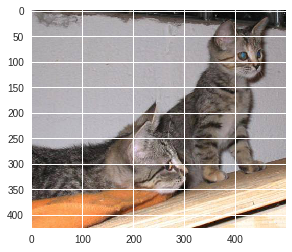

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

### **Main Stuff**

In [10]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 98982175.01it/s]


100%|██████████| 32/32 [00:15<00:00,  2.10it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.05874    0.023917   0.991     
    1      0.03396    0.024299   0.989     



[array([0.0243]), 0.989]

In [11]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [12]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [13]:

# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [14]:
log_preds[:10]

array([[ -0.00286,  -5.85759],
       [ -0.00063,  -7.37516],
       [ -0.00852,  -4.76928],
       [ -0.00006,  -9.75496],
       [ -0.00058,  -7.4513 ],
       [ -0.00651,  -5.03773],
       [ -0.00002, -10.77551],
       [ -0.00003, -10.4213 ],
       [ -0.00009,  -9.31303],
       [ -0.05397,  -2.94627]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


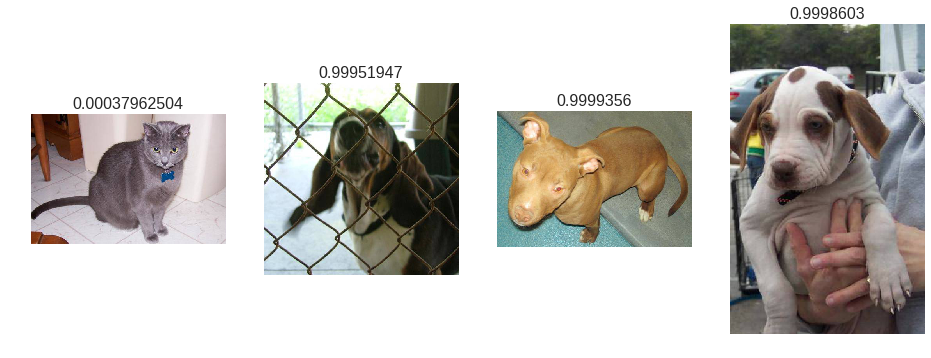

In [19]:

# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


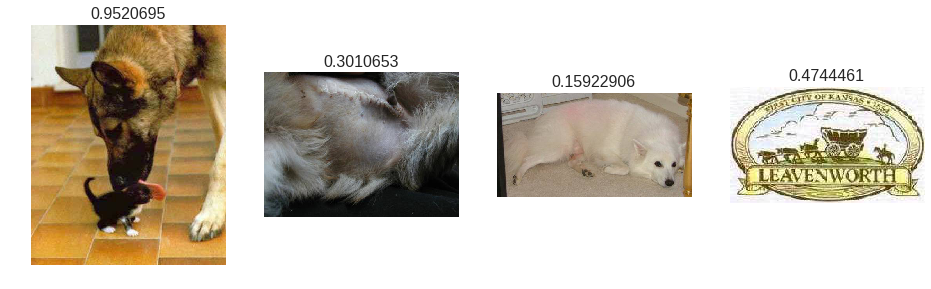

In [20]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


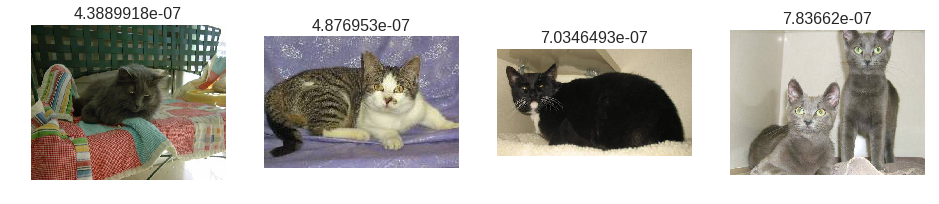

In [22]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


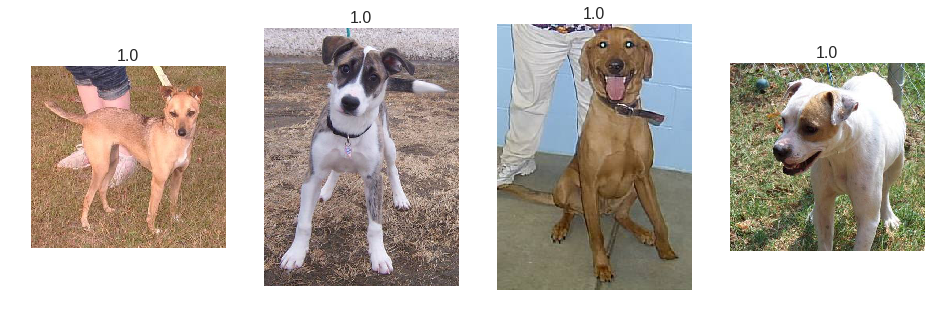

In [23]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


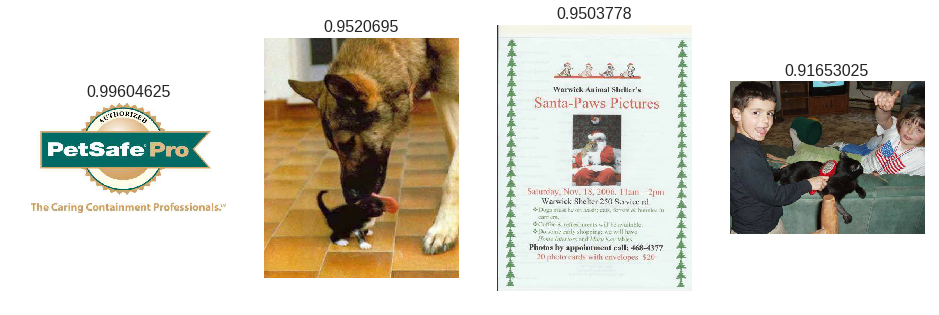

In [24]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


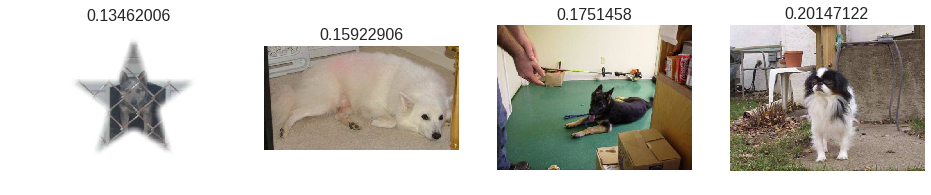

In [25]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


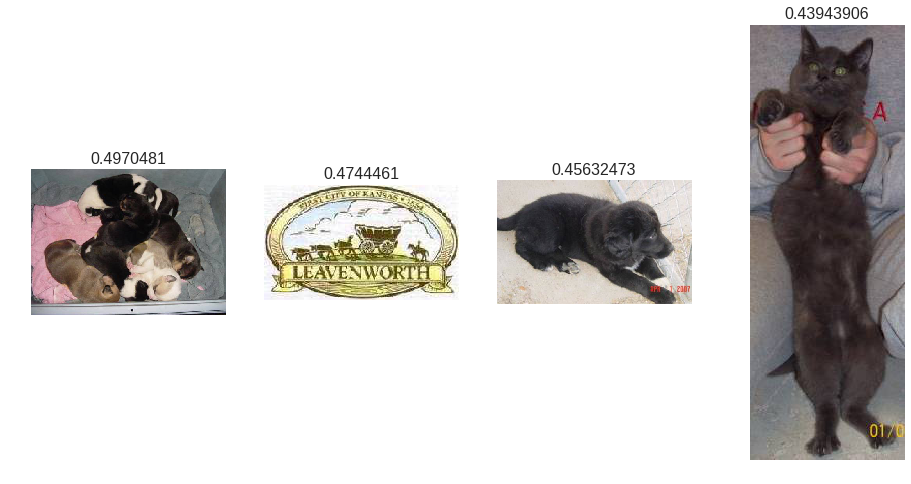

In [26]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### **Lesson 2**

In [0]:
#choosing a learning rate
learn = ConvLearner.pretrained(arch, data, precompute=True)


In [28]:
lrf=learn.lr_find()


 84%|████████▍ | 302/360 [00:07<00:01, 49.03it/s, loss=0.449]


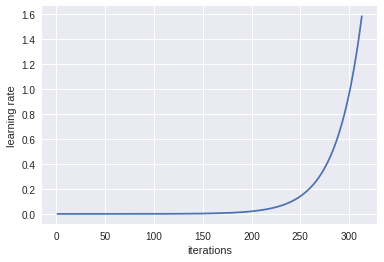

In [29]:
learn.sched.plot_lr()

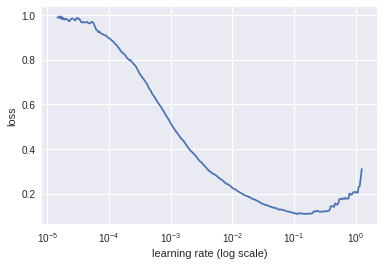

In [30]:
learn.sched.plot()
# should select learning rate just before the lowest point


In [0]:
# just this data and multiple epochs can cause overfitting so we augument the data by rotating the images
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)


In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]


In [0]:
ims = np.stack([get_augs() for i in range(6)])


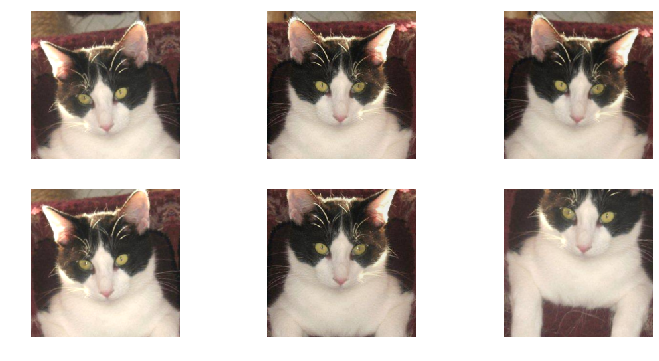

In [34]:
plots(ims, rows=2)


In [0]:
# for augumentation to work we need to do precompute = false

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [36]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.05317    0.028355   0.991     



[array([0.02835]), 0.991]

In [0]:
learn.precompute=False

In [38]:
learn.fit(1e-2, 3, cycle_len=1) 
# we added more epochs without overfitting and this cyclelen is the number of cycles the 
# epochs are required to run or the number of times learning rate is reset every n epoch

epoch      trn_loss   val_loss   accuracy   
    0      0.050125   0.027245   0.9905    
    1      0.052045   0.026205   0.9905    
    2      0.041933   0.026721   0.9895    



[array([0.02672]), 0.9895]

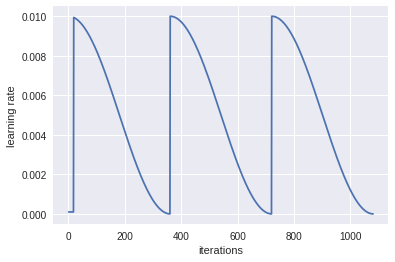

In [39]:
learn.sched.plot_lr()


In [0]:
# saving model and loading without training it from ground up
learn.save('224_lastlayer')


In [0]:
learn.load('224_lastlayer')


In [0]:
learn.unfreeze()


In [0]:
# setting different learning rates for different layers as we dont need much for basic stuff
lr=np.array([1e-4,1e-3,1e-2]) 



In [44]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) # cycle mult increases the length of cycle by a factor


epoch      trn_loss   val_loss   accuracy   
    0      0.049744   0.024996   0.991     
    1      0.041601   0.023382   0.991     
    2      0.037934   0.022572   0.9915    
    3      0.032842   0.021215   0.9905    
    4      0.027554   0.022115   0.9905    
    5      0.017774   0.021381   0.9915    
    6      0.019334   0.021185   0.9915    



[array([0.02118]), 0.9915]

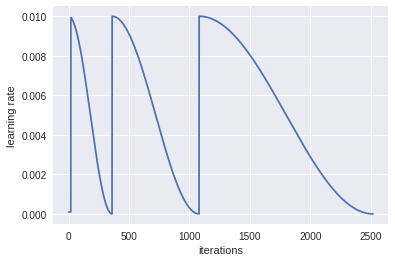

In [45]:
learn.sched.plot_lr() 
